## FNN results notebook

This notebook loads a trained FNN checkpoint (saved from `FNN_optuna.ipynb`), reconstructs the model + normalizers, plots predictions vs. the analytic ground truth, and computes relative errors on a dense grid.

In [46]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)
device = torch.device("cpu")
print("Device:", device)

Device: cpu


In [47]:
# ---- Exact (analytic) solution used to generate the dataset ----
# u(x,t) = sin(x) * cos(4*pi*t)
# f(x,t) = (1 - 16*pi^2) * sin(x) * cos(4*pi*t)

def u_exact(x, t):
    return torch.sin(x) * torch.cos(4 * torch.pi * t)

def f_exact(x, t):
    return (1 - 16 * torch.pi**2) * torch.sin(x) * torch.cos(4 * torch.pi * t)

# Domain parameters (match FNN_optuna.ipynb)
L = float(torch.pi)
t_end = 2.0

In [48]:
# ---- Model definition (must match training) ----
# Note: input includes a bias column of ones => input_size = 3 (x, t, bias)
# output is (f, u) => output_size = 2

class FNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_features=64, activation_function=nn.ReLU()):
        super().__init__()
        self.activation_function = activation_function
        self.linear_layer_1 = nn.Linear(input_size, hidden_features, bias=True)
        self.linear_layer_2 = nn.Linear(hidden_features, hidden_features, bias=True)
        self.linear_layer_3 = nn.Linear(hidden_features, hidden_features, bias=True)
        self.linear_layer_4 = nn.Linear(hidden_features, output_size, bias=True)

    def forward(self, x):
        x = self.linear_layer_1(x)
        x = self.activation_function(x)
        x = self.linear_layer_2(x)
        x = self.activation_function(x)
        x = self.linear_layer_3(x)
        x = self.activation_function(x)
        x = self.linear_layer_4(x)
        return x

In [49]:
# ---- Normalizer helpers (rebuild from saved mean/std) ----
class FixedNormalizer:
    def __init__(self, mean, std):
        self.normmean = torch.as_tensor(mean, dtype=torch.float32)
        self.normstd = torch.as_tensor(std, dtype=torch.float32)

    def normalize(self, data):
        mean = self.normmean.to(device=data.device, dtype=data.dtype)
        std = self.normstd.to(device=data.device, dtype=data.dtype)
        return (data - mean) / std

    def denormalize(self, data):
        mean = self.normmean.to(device=data.device, dtype=data.dtype)
        std = self.normstd.to(device=data.device, dtype=data.dtype)
        return data * std + mean

def resolve_models_dir():
    # Robust to different kernel working directories
    candidates = ["models", os.path.join("FNN", "models")]
    for p in candidates:
        if os.path.isdir(p):
            return p
    # If nothing exists yet, default to ./models
    os.makedirs(candidates[0], exist_ok=True)
    return candidates[0]

def load_latest_checkpoint(models_dir, pattern="fnn_best_*.pt"):
    paths = sorted(glob.glob(os.path.join(models_dir, pattern)), key=os.path.getmtime)
    if not paths:
        raise FileNotFoundError(f"No checkpoints found in {models_dir} (pattern={pattern}).")
    return paths[-1]

def safe_torch_load(path, map_location):
    # Prefer weights_only where available; fall back gracefully
    try:
        return torch.load(path, map_location=map_location, weights_only=True)
    except TypeError:
        return torch.load(path, map_location=map_location)
    except Exception as e:
        print("weights_only load failed, retrying full load:", repr(e))
        return torch.load(path, map_location=map_location, weights_only=False)

In [53]:
# ---- Load best_fnn.pt (weights) + normalizers_FNN.pt (scalers) ----
print("CWD:", os.getcwd())

def find_latest_file(glob_patterns):
    matches = []
    for pat in glob_patterns:
        matches.extend(glob.glob(pat, recursive=True))
    matches = [p for p in matches if os.path.isfile(p)]
    if not matches:
        return None
    return max(matches, key=os.path.getmtime)

# Locate weights + normalizers (works regardless of whether CWD is repo root or ./FNN)
best_weights_path = find_latest_file([
    os.path.join("models", "best_fnn.pt"),
    os.path.join("FNN", "models", "best_fnn.pt"),
    os.path.join("**", "models", "best_fnn.pt"),
    os.path.join("**", "best_fnn.pt"),
])
if best_weights_path is None:
    raise FileNotFoundError("Could not find best_fnn.pt. Run the final training cell in FNN_optuna.ipynb first.")

models_dir = os.path.dirname(best_weights_path)
print("Using models_dir:", models_dir)
print("Loaded best weights:", best_weights_path)

state_dict = safe_torch_load(best_weights_path, map_location=device)

# Optional metadata checkpoint (if present)
ckpt_path = find_latest_file([
    os.path.join(models_dir, "fnn_best_*.pt"),
    os.path.join("models", "fnn_best_*.pt"),
    os.path.join("FNN", "models", "fnn_best_*.pt"),
    os.path.join("**", "models", "fnn_best_*.pt"),
    os.path.join("**", "fnn_best_*.pt"),
])
checkpoint = None
if ckpt_path is not None:
    checkpoint = safe_torch_load(ckpt_path, map_location=device)
    print("Loaded metadata checkpoint:", ckpt_path)

# Load normalizers (prefer near best_fnn.pt)
norms_path = os.path.join(models_dir, "normalizers_FNN.pt")
if not os.path.isfile(norms_path):
    norms_path = find_latest_file([
        os.path.join("models", "normalizers_FNN.pt"),
        os.path.join("FNN", "models", "normalizers_FNN.pt"),
        os.path.join("**", "models", "normalizers_FNN.pt"),
        os.path.join("**", "normalizers_FNN.pt"),
    ])
if norms_path is None:
    raise FileNotFoundError("Could not find normalizers_FNN.pt.")
norms = safe_torch_load(norms_path, map_location="cpu")
print("Loaded normalizers:", norms_path)

x_normalizer = FixedNormalizer(norms["x_mean"], norms["x_std"])
t_normalizer = FixedNormalizer(norms["t_mean"], norms["t_std"])
f_normalizer = FixedNormalizer(norms["f_mean"], norms["f_std"])
u_normalizer = FixedNormalizer(norms["u_mean"], norms["u_std"])

# Rebuild model architecture from state_dict shapes
w1 = state_dict["linear_layer_1.weight"]
w4 = state_dict["linear_layer_4.weight"]
input_size = int(w1.shape[1])
hidden_features = int(w1.shape[0])
output_size = int(w4.shape[0])

activation_map = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "SiLU": nn.SiLU(), "ELU": nn.ELU()}

def rel_l2_percent(pred, true, eps=1e-12):
    return (torch.linalg.norm(pred - true) / (torch.linalg.norm(true) + eps) * 100).item()

def quick_score_for_activation(act_name, nx=100, nt=80):
    # Build model with candidate activation and score on a small grid
    m = FNN(
        input_size=input_size,
        output_size=output_size,
        hidden_features=hidden_features,
        activation_function=activation_map[act_name],
    ).to(device)
    m.load_state_dict(state_dict)
    m.eval()

    xv = torch.linspace(0.0, L, steps=nx, dtype=torch.float32)
    tv = torch.linspace(0.0, t_end, steps=nt, dtype=torch.float32)
    X, T = torch.meshgrid(xv, tv, indexing="ij")
    xg = X.reshape(-1, 1)
    tg = T.reshape(-1, 1)
    bias = torch.ones_like(xg)

    x_n = x_normalizer.normalize(xg)
    t_n = t_normalizer.normalize(tg)
    inp = torch.cat([x_n, t_n, bias], dim=1).to(device)

    with torch.no_grad():
        y_hat_n = m(inp).cpu()

    f_hat = f_normalizer.denormalize(y_hat_n[:, 0])
    u_hat = u_normalizer.denormalize(y_hat_n[:, 1])
    f_true = f_exact(xg.squeeze(1), tg.squeeze(1))
    u_true = u_exact(xg.squeeze(1), tg.squeeze(1))

    ef = rel_l2_percent(f_hat, f_true)
    eu = rel_l2_percent(u_hat, u_true)
    return ef, eu, (ef + eu) / 2.0

# Activation: prefer checkpoint best_params; otherwise auto-detect by trying candidates
activation_name = None
if checkpoint is not None and isinstance(checkpoint, dict):
    best = checkpoint.get("best_params", None)
    if isinstance(best, dict):
        activation_name = best.get("activation", None)

if activation_name is None:
    print("No activation metadata found. Auto-detecting activation by scoring candidates...")
    scores = {}
    for act in activation_map.keys():
        ef, eu, avg = quick_score_for_activation(act)
        scores[act] = (avg, ef, eu)
        print(f"  {act}: avg={avg:.3f}% (f={ef:.3f}%, u={eu:.3f}%)")
    activation_name = min(scores.keys(), key=lambda k: scores[k][0])
    print("Selected activation:", activation_name)

model = FNN(
    input_size=input_size,
    output_size=output_size,
    hidden_features=hidden_features,
    activation_function=activation_map[activation_name],
).to(device)
model.load_state_dict(state_dict)
model.eval()

print("Model rebuilt with:", {"input_size": input_size, "hidden_features": hidden_features, "output_size": output_size, "activation": activation_name})

CWD: c:\Users\bart\OneDrive - Delft University of Technology\Master\DSAIE\Github\CEGM2003-BEAM-Project-2025-26\FNN
Using models_dir: models
Loaded best weights: models\best_fnn.pt
Loaded normalizers: models\normalizers_FNN.pt
No activation metadata found. Auto-detecting activation by scoring candidates...
  ReLU: avg=565.000% (f=566.519%, u=563.480%)
  Tanh: avg=228.283% (f=228.730%, u=227.837%)
  SiLU: avg=0.931% (f=0.931%, u=0.931%)
  ELU: avg=398.828% (f=398.995%, u=398.661%)
Selected activation: SiLU
Model rebuilt with: {'input_size': 3, 'hidden_features': 128, 'output_size': 2, 'activation': 'SiLU'}


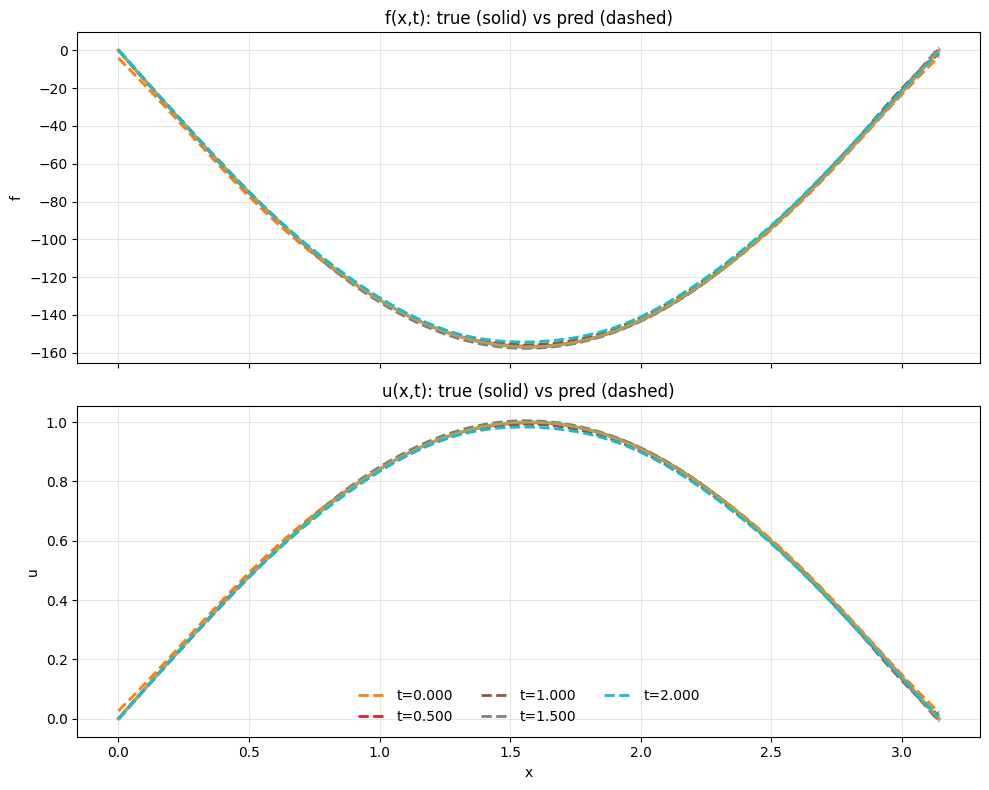

In [54]:
# ---- Plot f(x,t) and u(x,t) at multiple time instants ----
def predict_f_u(model, x, t):
    # x,t expected shapes: (N,1) or (N,)
    x = x.reshape(-1, 1)
    t = t.reshape(-1, 1)
    bias = torch.ones_like(x)

    x_n = x_normalizer.normalize(x)
    t_n = t_normalizer.normalize(t)
    inp = torch.cat([x_n, t_n, bias], dim=1).to(device)

    with torch.no_grad():
        y_hat_n = model(inp).cpu()

    f_hat = f_normalizer.denormalize(y_hat_n[:, 0])
    u_hat = u_normalizer.denormalize(y_hat_n[:, 1])
    return f_hat, u_hat

def plot_curves(times, n_x=300):
    x = torch.linspace(0.0, L, steps=n_x, dtype=torch.float32)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for t0 in times:
        t = torch.full_like(x, fill_value=float(t0))
        f_hat, u_hat = predict_f_u(model, x, t)
        f_true = f_exact(x, t)
        u_true = u_exact(x, t)

        axes[0].plot(x.numpy(), f_true.numpy(), lw=2, alpha=0.6)
        axes[0].plot(x.numpy(), f_hat.numpy(), lw=2, ls='--', label=f"t={float(t0):.3f}")
        axes[1].plot(x.numpy(), u_true.numpy(), lw=2, alpha=0.6)
        axes[1].plot(x.numpy(), u_hat.numpy(), lw=2, ls='--', label=f"t={float(t0):.3f}")

    axes[0].set_title('f(x,t): true (solid) vs pred (dashed)')
    axes[0].set_ylabel('f')
    axes[0].grid(True, alpha=0.3)
    axes[1].set_title('u(x,t): true (solid) vs pred (dashed)')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('u')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(ncol=3, frameon=False)
    plt.tight_layout()
    plt.show()

times = np.linspace(0.0, t_end, 5)
plot_curves(times)

In [55]:
# ---- Relative errors on a dense (x,t) grid ----
def rel_l2_percent(pred, true, eps=1e-12):
    return (torch.linalg.norm(pred - true) / (torch.linalg.norm(true) + eps) * 100).item()

def compute_grid_relative_errors(nx=200, nt=200):
    xv = torch.linspace(0.0, L, steps=nx, dtype=torch.float32)
    tv = torch.linspace(0.0, t_end, steps=nt, dtype=torch.float32)
    X, T = torch.meshgrid(xv, tv, indexing='ij')
    xg = X.reshape(-1, 1)
    tg = T.reshape(-1, 1)

    f_hat, u_hat = predict_f_u(model, xg, tg)
    f_true = f_exact(xg.squeeze(1), tg.squeeze(1))
    u_true = u_exact(xg.squeeze(1), tg.squeeze(1))

    err_f = rel_l2_percent(f_hat, f_true)
    err_u = rel_l2_percent(u_hat, u_true)
    print(f"Grid relative L2 error (f): {err_f:.6f}%")
    print(f"Grid relative L2 error (u): {err_u:.6f}%")

compute_grid_relative_errors()

Grid relative L2 error (f): 0.922000%
Grid relative L2 error (u): 0.921983%
